In [1]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure
from tqdm import tqdm

In [2]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
# model64 = models.mobilenet_v3_large()
# model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model128 = models.mobilenet_v3_small()
model128.classifier[0] = torch.nn.Linear(576,1280)
model128.classifier[3] = torch.nn.Linear(1280,1000)
model128.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
# model128 = models.mobilenet_v3_small()
# model128.classifier[0] = torch.nn.Linear(576,1280)
# model128.classifier[3] = torch.nn.Linear(1280,1000)
# model128.load_state_dict(torch.load("mnv3s/best_batch_i342323v3_small_frozen_head1676029877.1912067.pth")['model_state_dict'])
model128.to('cuda')
model.eval()
model128.eval()

activationT = {}
activationS = {}
def get_activationT(name):
    def hook(model, input, output):
        activationT[name] = output.detach()
    return hook
def get_activationS(name):
    def hook(model, input, output):
        activationS[name] = output.detach()
    return hook

model.classifier[0].register_forward_hook(get_activationT('emb'))
model128.classifier[0].register_forward_hook(get_activationS('emb'))
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

In [11]:
clean_embds,clean_labels,clean_preds = torch.load("embds/clean224.pt")
clean_embds128,clean_labels128,clean_preds128 = torch.load("embds/clean128.pt")
corr_embds = []
corr_labels = []
corr_preds = []
corr_embds128 = []
corr_labels128 = []
corr_preds128 = []
corr_embds64 = []
corr_labels64 = []
corr_preds64 = []
for i,corr in enumerate(corruptions):
    e,l,p = torch.load("embds/corr224_"+corr+".pt")
    e128,l128,p128 = torch.load("embds/corr128_"+corr+".pt")
    # e64,l64,p64 = torch.load("embds/corr64_"+corr+".pt")
    corr_embds.append(e)
    corr_labels.append(l)
    corr_preds.append(p)
    corr_embds128.append(e128)
    corr_labels128.append(l128)
    corr_preds128.append(p128)
    # corr_embds64.append(e64)
    # corr_labels64.append(l64)
    # corr_preds64.append(p64)

clean_results128 = (torch.argmax(clean_preds128,dim=1) == clean_labels)
clean_results = (torch.argmax(clean_preds,dim=1) == clean_labels)

class FC(torch.nn.Module):
    def __init__(self,feats):
      super(FC, self).__init__()
      self.c = torch.nn.Linear(feats,1000)
    def forward(self,x):
      return self.c(x)
fcs = FC(1280).eval()
fct = FC(1280).eval()
with torch.no_grad():
  fcs.c.weight[:,:] = model128.classifier[3].weight[:,:]
  fcs.c.bias[:] = model128.classifier[3].bias[:]
  fct.c.weight[:,:] = model.classifier[3].weight[:,:]
  fct.c.bias[:] = model.classifier[3].bias[:]

In [132]:
'''
methods should follow a modular structure by inheriting from
the abstract base class 'Policy'.
'''

from abc import ABC, abstractmethod
CHOOSE_STUDENT = False
CHOOSE_TEACHER = True

class Policy(ABC):
    # provide the student cost, teacher cost, and budget for the internal parameters
    @abstractmethod
    def initialize(self,student_cost: int, teacher_cost: int, budget: int):
        pass

    # execute the policy by giving it the next sample (student embedding tensor)
    # the policy returns a bool: 0 for student, 1 for teacher/label
    @abstractmethod
    def execute(self, next_sample: torch.Tensor) -> bool:
        pass

    # reset the policy for new round of execution, clear internal state
    @abstractmethod
    def reset(self):
        pass

    # name of the policy
    @abstractmethod
    def __str__(self):
        pass


class EvalPolicy():
    # takes in a list of policies (type Policy)
    def __init__(self,policies: list, input_samples: torch.Tensor, student_results: torch.Tensor, \
                teacher_results: torch.Tensor, student_cost: int, teacher_cost: int, budgets: torch.Tensor) -> None:
        # input parameters
        self.policies = policies
        self.input_samples = input_samples
        self.student_results = student_results
        self.teacher_results = teacher_results
        self.student_cost = student_cost
        self.teacher_cost = teacher_cost
        self.budgets = budgets

        # additional variables
        self.decisions = torch.zeros((len(policies),len(budgets),len(input_samples)))
        self.costs = torch.zeros((len(policies),len(budgets),len(input_samples)))
        self.results = torch.zeros((len(policies),len(budgets),len(input_samples)))

        self.final_costs = torch.zeros((len(policies),len(budgets)))
        self.final_accuracies = torch.zeros((len(policies),len(budgets)))
    
    def evaluate(self):
        print("# ===================== Starting Evaluation ===================== #")
        # evaluate each policy
        for policy_i,policy in enumerate(self.policies):
            print(f"Policy: {policy} ({policy_i+1}/{len(self.policies)})")
            for budget_i,budget in enumerate(self.budgets):
                policy.reset()
                policy.initialize(self.student_cost,self.teacher_cost,budget)
                print(f"Budget: {budget} ({budget_i+1}/{len(self.budgets)})")
                # for each policy go through evaluation process
                for sample_i,sample in enumerate(tqdm(self.input_samples)):
                    # get the policy decision
                    decision = policy.execute(sample)
                    self.decisions[policy_i,budget_i,sample_i] = decision
                    # update the policy cost
                    self.costs[policy_i,budget_i,sample_i] += self.student_cost if (decision == CHOOSE_STUDENT) else (self.student_cost+self.teacher_cost)
                    # check that the policy stays in budget
                    assert torch.sum(self.costs[policy_i,budget_i,:sample_i+1])/(sample_i+1) <= budget, \
                        f"Policy {policy} has average cost {sum(self.costs[policy_i,budget_i,:sample_i+1])/(sample_i+1)} which exceeds budget {budget}."
                    self.results[policy_i,budget_i,sample_i] = self.student_results[sample_i] if (decision == CHOOSE_STUDENT) else self.teacher_results[sample_i]

                # after evaluating the policy, update its final cost and accuracy
                self.final_costs[policy_i,budget_i] = torch.sum(self.costs[policy_i,budget_i,:])/len(self.input_samples)
                self.final_accuracies[policy_i,budget_i] = torch.sum(self.results[policy_i,budget_i,:])/len(self.input_samples)

    def plot_results(self):
        fig, ax = plt.subplots()
        cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        legends = []
        handles_ = [[] for i in range(len(self.policies)+1)]
        for policy_i,policy in enumerate(self.policies):
            for budget_i, budget in enumerate(self.budgets):
                if policy_i == 0:
                    handles_[policy_i].append(ax.axvline(budget,label="budget: "+str(budget),c='k',alpha=(budget_i+1)/(len(self.budgets)+1)))
                handles_[policy_i+1].append(ax.scatter(self.final_costs[policy_i,budget_i],self.final_accuracies[policy_i,budget_i],label=str(policy)+": "+str(budget),c=cycle[policy_i],alpha=(budget_i+1)/(len(self.budgets)+1),edgecolors='black'))
            legends.append(ax.legend(handles=handles_[policy_i+1],bbox_to_anchor=(1.0+0.3*(policy_i+1),1.05)))
        ax.legend(handles=handles_[0],bbox_to_anchor=(1.0,1.05))
        for policy_i,policy in enumerate(self.policies):
            ax.add_artist(legends[policy_i])
        plt.title("Cost vs Accuracy")
        plt.xlabel("Cost MACs (M)")
        plt.ylabel("Accuracy")
        


In [133]:
class RandomPolicy(Policy):
    def initialize(self,student_cost,teacher_cost, budget) -> None:
        # save policy variables
        self.student_cost = student_cost
        self.teacher_cost = teacher_cost
        self.budget = budget

        # set policy threshold based off of budget
        # p*student_cost + (1-p)*teacher_cost <= budget
        self.p = (teacher_cost-budget)/(teacher_cost-student_cost)

        # keep track of avg cost internall so don't exceed budget
        self.total_cost = 0
        self.total_cost_counts = 0

    def execute(self, next_sample: torch.Tensor) -> bool:
        # make decision randomly
        decision = torch.rand(1) > self.p

        # update cost
        new_total_cost = (self.total_cost+self.student_cost) if (decision == 0) else (self.total_cost+self.student_cost+self.teacher_cost)

        # if exceed threshold, then choose student
        if new_total_cost/(self.total_cost_counts+1) > self.budget:
            self.total_cost += self.student_cost
            self.total_cost_counts += 1
            return CHOOSE_STUDENT
        
        self.total_cost = new_total_cost
        self.total_cost_counts += 1
        return decision

    def reset(self):
        self.total_cost = 0
        self.total_cost_counts = 0

    def __str__(self):
        return "Random Policy"

# ===================== Starting Evaluation ===================== #
Policy: Random Policy (1/1)
Budget: 1.0 (1/11)


100%|██████████| 50000/50000 [00:02<00:00, 18188.67it/s]


Budget: 2.0 (2/11)


100%|██████████| 50000/50000 [00:02<00:00, 18225.62it/s]


Budget: 3.0 (3/11)


100%|██████████| 50000/50000 [00:02<00:00, 17905.74it/s]


Budget: 4.0 (4/11)


100%|██████████| 50000/50000 [00:02<00:00, 18269.69it/s]


Budget: 5.0 (5/11)


100%|██████████| 50000/50000 [00:02<00:00, 18452.83it/s]


Budget: 6.0 (6/11)


100%|██████████| 50000/50000 [00:02<00:00, 17759.14it/s]


Budget: 7.0 (7/11)


100%|██████████| 50000/50000 [00:02<00:00, 17915.79it/s]


Budget: 8.0 (8/11)


100%|██████████| 50000/50000 [00:02<00:00, 18527.82it/s]


Budget: 9.0 (9/11)


100%|██████████| 50000/50000 [00:02<00:00, 18427.30it/s]


Budget: 10.0 (10/11)


100%|██████████| 50000/50000 [00:02<00:00, 17193.78it/s]


Budget: 11.0 (11/11)


100%|██████████| 50000/50000 [00:02<00:00, 18336.43it/s]


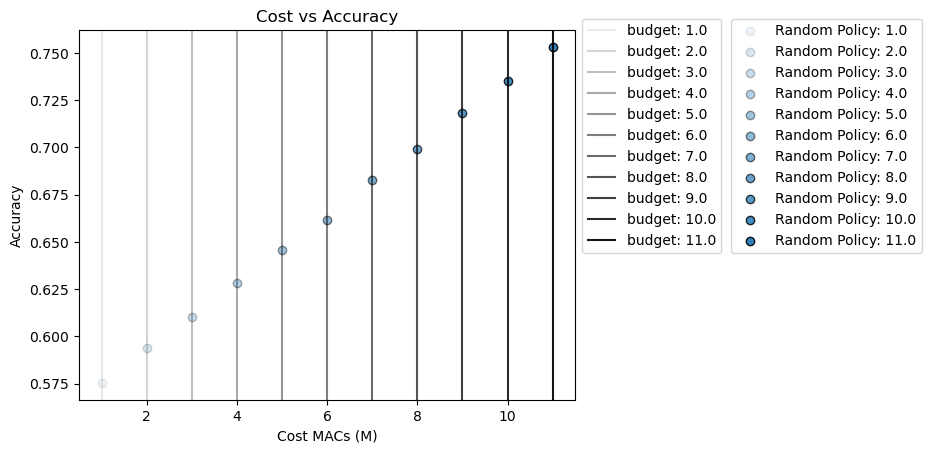

In [134]:
s_cost = 1
t_cost = 11
budgets = np.linspace(s_cost,t_cost,11)
policies = []
policies.append(RandomPolicy())

Eval = EvalPolicy(policies,clean_embds128,clean_results128,clean_results,1,10,budgets)

Eval.evaluate()
Eval.plot_results()